In [108]:
import pandas as pd 
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from pingouin import power_anova 

In [109]:
data = pd.read_excel('all_cohorts_freezing_FINAL.xlsx')
data['cohort_id'] = data['cohort'].astype(str) + '-' + data['id'].astype(str)

dob_data = pd.read_excel('id_dob.xlsx')
dob_data['cohort_id'] = dob_data['cohort'].astype(str) + '-' + dob_data['id'].astype(str)  

data = pd.merge(data, dob_data, on =['cohort_id', 'id', 'cohort'])

data['age_at_sefla'] = None

for idx, row in data.iterrows():
    if row['day'] == 'sefla':
        data.at[idx, 'age_at_sefla'] = (row['date'] - row['dob']).days / 7
    else:
        sefla_row = data[(data['cohort_id'] == row['cohort_id']) & (data['day'] == 'sefla')]
        if not sefla_row.empty:
            data.at[idx, 'age_at_sefla'] = sefla_row.iloc[0]['age_at_sefla']

data['age_at_sefla'] = data['age_at_sefla'].astype(float)

data = data[(data['day'] != 'sefla') & (data['day'] != 'recall6') & (data['day'] != 'recall7')]

data.head()


,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,psilocybin,cohort_id,dob,age_at_sefla
1,8.94,2aFlox_het,5HT2Afl05a-5,seflb,control,male,ptsd1,3.5,3.5,2021-04-04,09:52:00,n,n,ptsd1-5HT2Afl05a-5,2020-12-11,16.142857
2,43.10,2aFlox_het,5HT2Afl05a-5,recall1,control,male,ptsd1,0.0,5.0,2021-04-05,09:35:00,n,n,ptsd1-5HT2Afl05a-5,2020-12-11,16.142857
3,22.61,2aFlox_het,5HT2Afl05a-5,recall2,control,male,ptsd1,5.0,5.0,2021-04-07,10:36:00,n,n,ptsd1-5HT2Afl05a-5,2020-12-11,16.142857
4,37.22,2aFlox_het,5HT2Afl05a-5,recall3,control,male,ptsd1,5.0,5.0,2021-04-09,10:17:00,n,n,ptsd1-5HT2Afl05a-5,2020-12-11,16.142857
5,26.09,2aFlox_het,5HT2Afl05a-5,recall4,control,male,ptsd1,5.0,5.0,2021-04-16,10:32:00,n,n,ptsd1-5HT2Afl05a-5,2020-12-11,16.142857


In [110]:
data[(data['els'] == 'y') & (data['id'] == 'WC29-2')]
data = data[data['cohort_id'] != 'els2-WC29-2']

In [111]:
data[data['els'] == 'y'].groupby('id')['age_at_sefla'].mean().describe()
data[(data['cohort'] == 'els1') | (data['cohort'] == 'els2')].groupby('id')['age_at_sefla'].mean().describe()
# both the rats who recieved els and in general the rats within els groups have an age distribution that the 25th percentile is 17.0, the 75th percentile is 22.0, the median is 19.0
# then to see which rats are more fit into this range 
data[(data['age_at_sefla'] > 16.7)&(data['age_at_sefla'] < 20)].groupby('id')['cohort'].unique().value_counts()
# so based on this rough filtering, ptsd13 and ptsd12 groups have a lot of rats in this age range. 

cohort
[els1]      28
[ptsd14]     8
[ptsd12]     8
[ptsd3]      5
[els2]       4
[ptsd1]      2
Name: count, dtype: int64

In [112]:
els_groups = data[(data['cohort'] == 'els1') | (data['cohort'] == 'els2')]
els1_group = els_groups[els_groups['cohort']=='els1']
els2_group = els_groups[els_groups['cohort']=='els2']

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


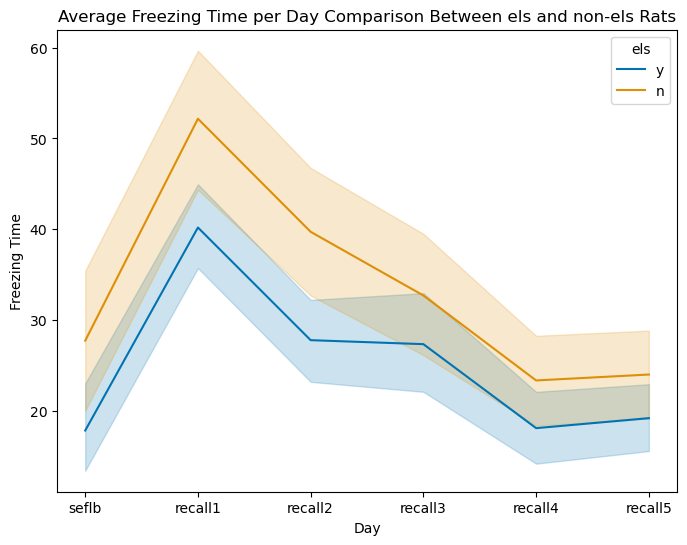

In [113]:
# lineplot for mean freezing time per day for els1 and els2 cohorts 
plt.figure(figsize=(8, 6))
sns.lineplot(data=els_groups, x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Average Freezing Time per Day Comparison Between els and non-els Rats')
plt.show()

In [114]:
# ANOVA on freezing time between els and non-els groups
overall_els_anova = pg.mixed_anova(data=els_groups, dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time between els and non-els groups:")
print(overall_els_anova)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=overall_els_anova['np2'].iloc[0], k=2, power=0.80))

print("There are {} rats in the els group".format(len(els_groups[els_groups['els'] == 'y']['id'].value_counts())))
print("There are {} rats in the non-els group".format(len(els_groups[els_groups['els'] == 'n']['id'].value_counts())))

repeated ANOVA for Freezing Time between els and non-els groups:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          els   6977.050850    1   71  6977.050850   7.393567  8.222070e-03   
1          day  33156.887873    5  355  6631.377575  45.687203  2.245337e-36   
2  Interaction   1025.853119    5  355   205.170624   1.413533  2.185881e-01   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.094313       NaN        NaN       NaN       NaN  
1  1.273443e-28  0.391536  0.772123      False  0.465791  0.000002  
2           NaN  0.019520       NaN        NaN       NaN       NaN  
The required sample size per group n: 38.6703
There are 45 rats in the els group
There are 28 rats in the non-els group


/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


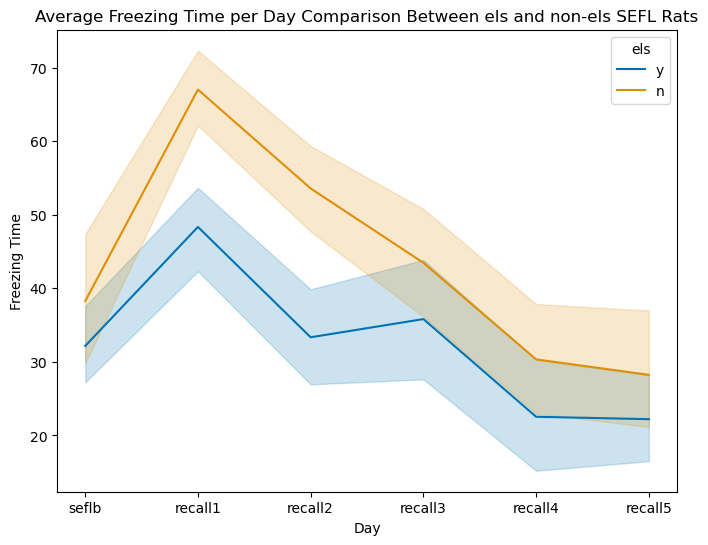

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


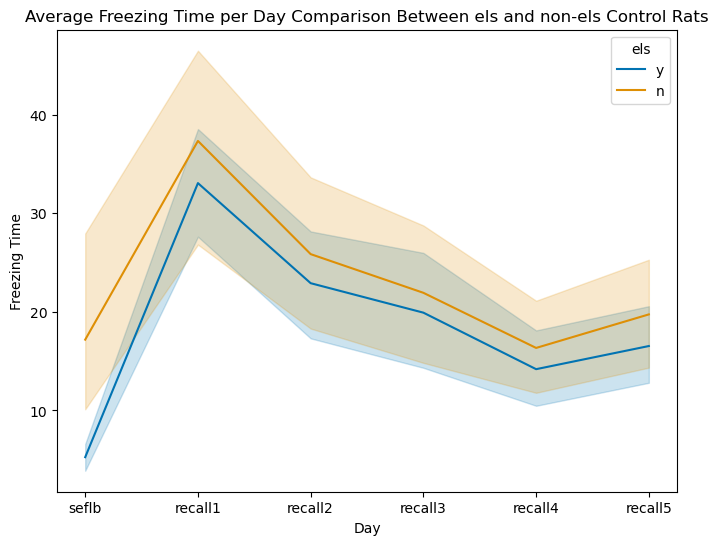

In [115]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=els_groups[els_groups['condition']=='sefl'], x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Average Freezing Time per Day Comparison Between els and non-els SEFL Rats')
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(data=els_groups[els_groups['condition']=='control'], x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Average Freezing Time per Day Comparison Between els and non-els Control Rats')
plt.show()

In [116]:
# ANOVA on freezing time between els and non-els in els1 group
sefl_els_comp = pg.mixed_anova(data=els_groups[els_groups['condition']=='sefl'], dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time between els and non-els Rats in SEFL group:")
print(sefl_els_comp)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=sefl_els_comp['np2'].iloc[0], k=2, power=0.80))

print("There are {} rats in SEFL group from els1 and els2 cohorts that received els".format(len(els_groups[(els_groups['condition']=='sefl') & (els_groups['els']=='y')]['id'].value_counts())))
print("There are {} rats in SEFL group from els1 and els2 cohorts that did not receive els".format(len(els_groups[(els_groups['condition']=='sefl') & (els_groups['els']=='n')]['id'].value_counts())))

# ANOVA on freezing time between els and non-els in els2 group
control_els_comp = pg.mixed_anova(data=els_groups[els_groups['condition']=='control'], dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time between els and non-els Rats in Control group:")
print(control_els_comp)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=control_els_comp['np2'].iloc[0], k=2, power=0.80))

print("There are {} rats in Control group from els1 and els2 cohorts that received els".format(len(els_groups[(els_groups['condition']=='control') & (els_groups['els']=='y')]['id'].value_counts())))
print("There are {} rats in Control group from els1 and els2 cohorts that did not receive els".format(len(els_groups[(els_groups['condition']=='control') & (els_groups['els']=='n')]['id'].value_counts())))

## this shows that within SEFL groups, els has a significant effect on freezing time, but within control groups, els has no significant effect on freezing time.

repeated ANOVA for Freezing Time between els and non-els Rats in SEFL group:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          els   6187.530712    1   33  6187.530712   9.968249  3.394250e-03   
1          day  23262.041805    5  165  4652.408361  29.591818  2.219159e-21   
2  Interaction   1800.473203    5  165   360.094641   2.290395  4.807846e-02   

      p-GG-corr       np2      eps sphericity   W-spher   p-spher  
0           NaN  0.231991      NaN        NaN       NaN       NaN  
1  6.659605e-15  0.472775  0.67663      False  0.368771  0.004062  
2           NaN  0.064901      NaN        NaN       NaN       NaN  
The required sample size per group n: 14.0203
There are 21 rats in SEFL group from els1 and els2 cohorts that received els
There are 14 rats in SEFL group from els1 and els2 cohorts that did not receive els
repeated ANOVA for Freezing Time between els and non-els Rats in Control group:
        Source            SS  DF1  DF2     

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


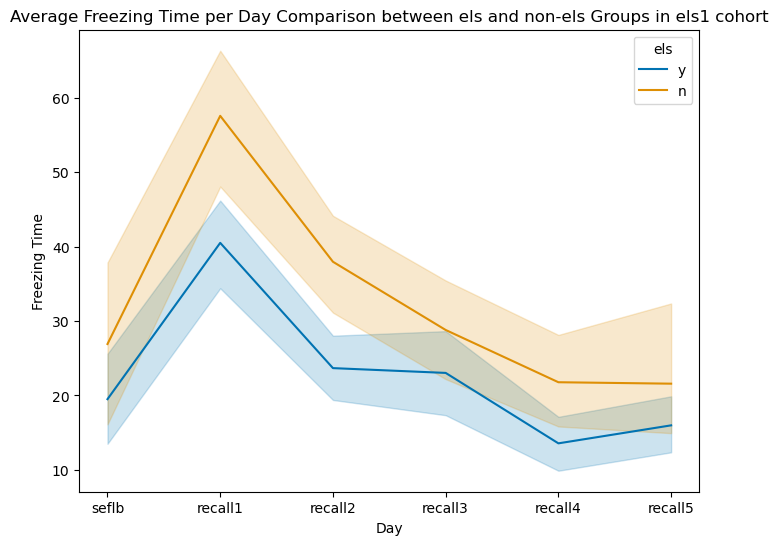

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


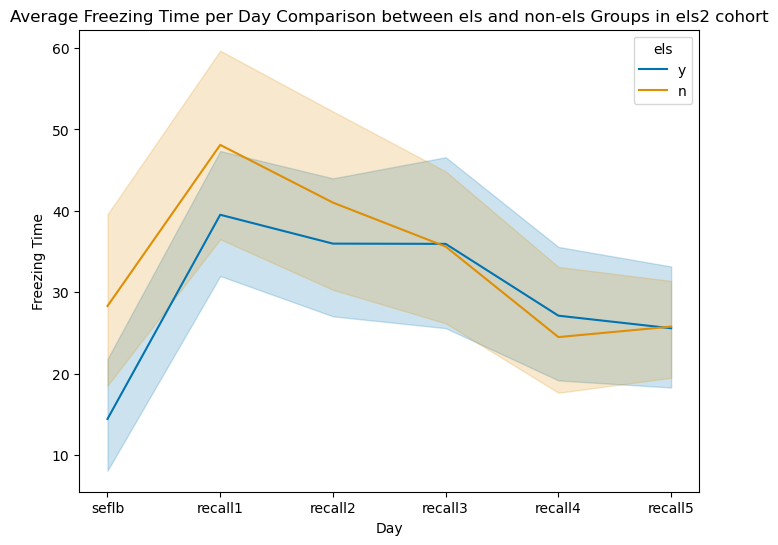

In [117]:
# lineplot for mean freezing time per day for els1 and els2 cohorts 
plt.figure(figsize=(8, 6))
sns.lineplot(data=els1_group, x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Average Freezing Time per Day Comparison between els and non-els Groups in els1 cohort')
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(data=els2_group, x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Average Freezing Time per Day Comparison between els and non-els Groups in els2 cohort')
plt.show()

In [118]:
# ANOVA on freezing time between els and non-els in els1 group
els1_anova = pg.mixed_anova(data=els1_group, dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time between els and non-els Rats in ELS 1 group:")
print(els1_anova)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=els1_anova['np2'].iloc[0], k=2, power=0.80))

print("There are {} rats in the els group within els1".format(len(els1_group[els1_group['els'] == 'y']['id'].value_counts())))
print("There are {} rats in the non-els group within els1".format(len(els1_group[els1_group['els'] == 'n']['id'].value_counts())))

# ANOVA on freezing time between els and non-els in els2 group
els2_anova = pg.mixed_anova(data=els2_group, dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time between els and non-els Rats in ELS 2 group:")
print(els2_anova)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=els2_anova['np2'].iloc[0], k=2, power=0.80))

print("There are {} rats in the els group within els2".format(len(els2_group[els2_group['els'] == 'y']['id'].value_counts())))
print("There are {} rats in the non-els group within els2".format(len(els2_group[els2_group['els'] == 'n']['id'].value_counts())))

repeated ANOVA for Freezing Time between els and non-els Rats in ELS 1 group:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          els   4871.671006    1   40  4871.671006   7.142159  1.084202e-02   
1          day  24010.596324    5  200  4802.119265  43.457658  3.347002e-30   
2  Interaction    987.694154    5  200   197.538831   1.787664  1.169082e-01   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.151503       NaN        NaN       NaN       NaN  
1  2.914215e-22  0.520715  0.719465      False  0.440121  0.003947  
2           NaN  0.042780       NaN        NaN       NaN       NaN  
The required sample size per group n: 22.9800
There are 30 rats in the els group within els1
There are 12 rats in the non-els group within els1
repeated ANOVA for Freezing Time between els and non-els Rats in ELS 2 group:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          els    788.4

In [119]:
els1_group_age = els1_group[els1_group['els'] == 'y'].groupby('id')['age_at_sefla'].first().reset_index()
nonels1_group_age = els1_group[els1_group['els'] == 'n'].groupby('id')['age_at_sefla'].first().reset_index()
els2_group_age = els2_group[els2_group['els'] == 'y'].groupby('id')['age_at_sefla'].first().reset_index()
nonels2_group_age = els2_group[els2_group['els'] == 'n'].groupby('id')['age_at_sefla'].first().reset_index()
pd.concat([els1_group_age.describe(), nonels1_group_age.describe(), els2_group_age.describe(), nonels2_group_age.describe()], axis=1)


,age_at_sefla,age_at_sefla,age_at_sefla,age_at_sefla
count,30.000000,12.000000,15.000000,16.000000
mean,17.066667,16.630952,21.123810,20.517857
std,0.427311,0.261708,1.085105,1.350107
min,16.428571,16.285714,20.000000,18.714286
25%,16.607143,16.428571,20.000000,19.678571
50%,17.142857,16.571429,20.428571,20.357143
75%,17.428571,16.785714,22.142857,22.000000
max,17.714286,17.000000,22.428571,22.000000


In [120]:
els1_sex = els1_group[els1_group['els'] == 'y'].groupby('id')['sex'].first().value_counts()
non_els1_sex = els1_group[els1_group['els'] == 'n'].groupby('id')['sex'].first().value_counts()
els2_sex = els2_group[els2_group['els'] == 'y'].groupby('id')['sex'].first().value_counts()
non_els2_sex = els2_group[els2_group['els'] == 'n'].groupby('id')['sex'].first().value_counts()
pd.concat([els1_sex, non_els1_sex, els2_sex, non_els2_sex], axis=1)


,count,count,count,count
sex,,,,
female,21,5,8,8
male,9,7,7,8


/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


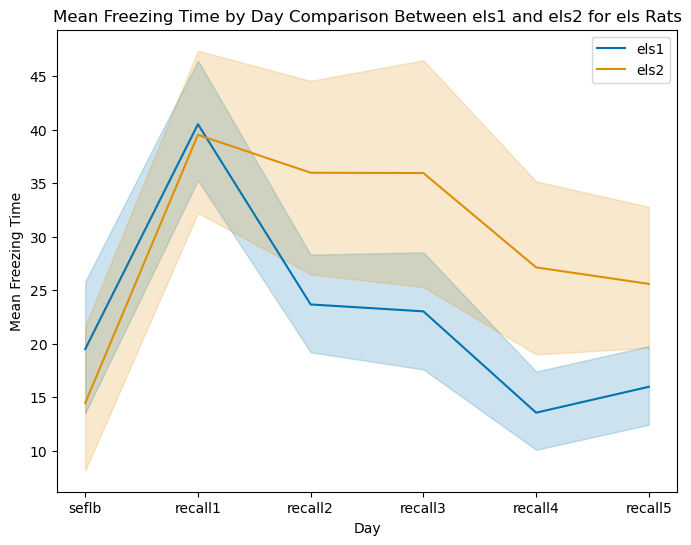

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


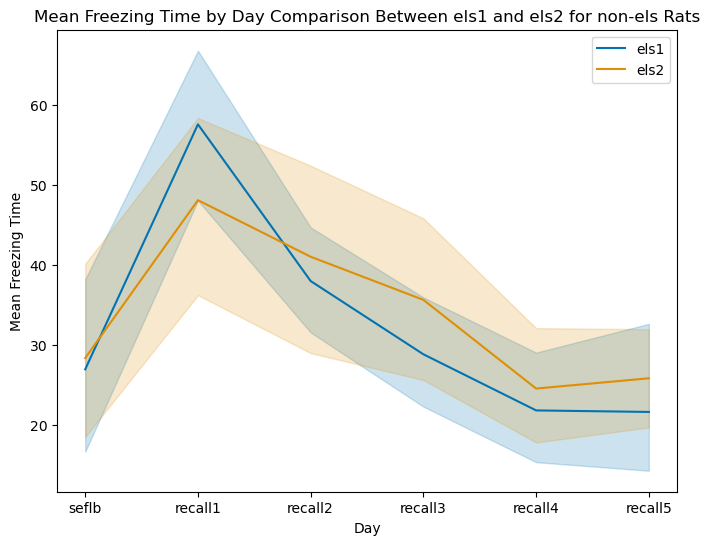

In [121]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=els_groups[els_groups['els']=='y'], x='day', y='freezing', hue='cohort', palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Mean Freezing Time')
plt.title('Mean Freezing Time by Day Comparison Between els1 and els2 for els Rats')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(data=els_groups[els_groups['els']=='n'], x='day', y='freezing', hue='cohort', palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Mean Freezing Time')
plt.title('Mean Freezing Time by Day Comparison Between els1 and els2 for non-els Rats')
plt.legend()
plt.show()


In [122]:
# ANOVA on freezing time for els rats between els1 and els2 
els_bw_12 = pg.mixed_anova(data=els_groups[els_groups['els']=='y'], dv='freezing', within='day', between='cohort', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time for els rats between els1 and els2 groups:")
print(els_bw_12)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=els_bw_12['np2'].iloc[0], k=2, power=0.80))
print("There are {} els rats in els1 group".format(len(els1_group[els1_group['els']=='y']['id'].value_counts())))
print("There are {} els rats in els2 group".format(len(els2_group[els2_group['els']=='y']['id'].value_counts())))
## we do not observe statistical significant difference for els rats between els1 and els2 groups, and we do not meet the required sample size. 

# ANOVA on freezing time for non-els rats between els1 and els2
non_els_bw_12 = pg.mixed_anova(data=els_groups[els_groups['els']=='n'], dv='freezing', within='day', between='cohort', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time for non-els rats between els1 and els2 groups:")
print(non_els_bw_12)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=non_els_bw_12['np2'].iloc[0], k=2, power=0.80))
print("There are {} non-els rats in els1 group".format(len(els1_group[els1_group['els']=='n']['id'].value_counts())))
print("There are {} non-els rats in els2 group".format(len(els2_group[els2_group['els']=='n']['id'].value_counts())))
## we also do not observe statistical significant difference flr non-els rats between els1 and els2 groups, and we also do not meet the required sample size. 


repeated ANOVA for Freezing Time for els rats between els1 and els2 groups:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0       cohort   2996.436269    1   43  2996.436269   3.664004  6.227000e-02   
1          day  16969.317606    5  215  3393.863521  32.175880  2.021152e-24   
2  Interaction   3222.539342    5  215   644.507868   6.110325  2.580151e-05   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.078519       NaN        NaN       NaN       NaN  
1  3.503455e-16  0.428008  0.688292      False  0.413739  0.000711  
2           NaN  0.124420       NaN        NaN       NaN       NaN  
The required sample size per group n: 47.0362
There are 30 els rats in els1 group
There are 15 els rats in els2 group
repeated ANOVA for Freezing Time for non-els rats between els1 and els2 groups:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0       cohort     86.974957    1   26    86.9749

In [123]:
els_groups['young'] = els_groups['age_at_sefla'] < 18.5
els_young = els_groups[els_groups['young']==True]
els_old = els_groups[els_groups['young']==False]

/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_46535/2657847924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  els_groups['young'] = els_groups['age_at_sefla'] < 18.5


/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


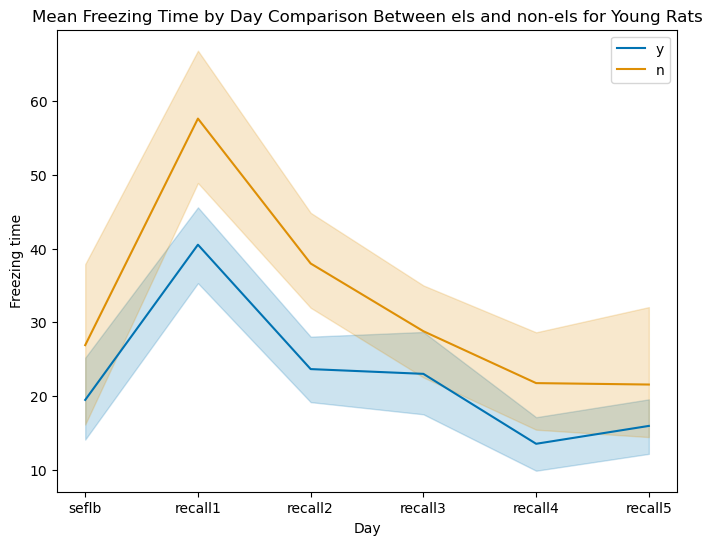

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


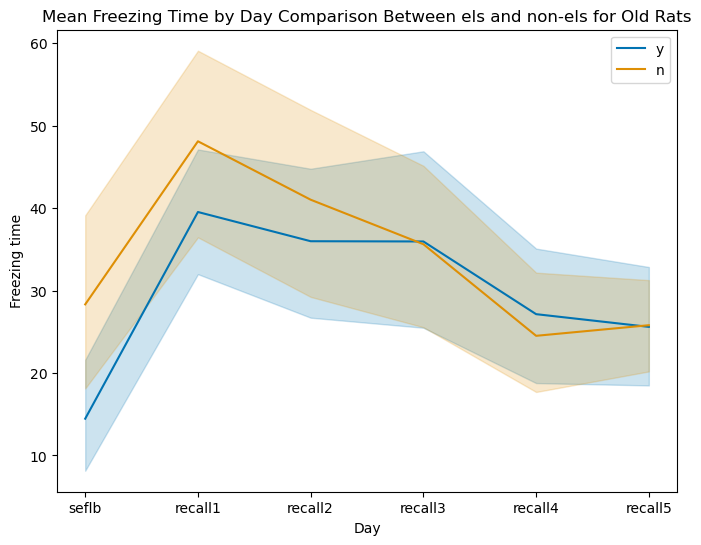

In [124]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=els_young, x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind") 
plt.xlabel('Day')
plt.ylabel('Freezing time')
plt.title('Mean Freezing Time by Day Comparison Between els and non-els for Young Rats')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(data=els_old, x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind") 
plt.xlabel('Day')
plt.ylabel('Freezing time')
plt.title('Mean Freezing Time by Day Comparison Between els and non-els for Old Rats')
plt.legend()
plt.show()

In [125]:
# ANOVA on freezing time for els and non-els young rats
els_young_anova = pg.mixed_anova(data=els_young, dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time for els and non-els young rats:")
print(els_young_anova)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=els_young_anova['np2'].iloc[0], k=2, power=0.80))
print("There are {} els young rats in els groups".format(len(els_young[els_young['els']=='y']['id'].value_counts())))
print("There are {} non-els young rats in els groups".format(len(els_young[els_young['els']=='n']['id'].value_counts())))
## We observe a significant difference between els and non-els young rats

# ANOVA on freezing time for els and non-els old rats
els_old_anova = pg.mixed_anova(data=els_old, dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time for els and non-els old rats:")
print(els_old_anova)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=els_old_anova['np2'].iloc[0], k=2, power=0.80))
print("There are {} els old rats in els groups".format(len(els_old[els_old['els']=='y']['id'].value_counts())))
print("There are {} non-els old rats in els groups".format(len(els_old[els_old['els']=='n']['id'].value_counts())))
## We don't observe a significant difference between els and non-els old rats, and we do not meet the required sample size.

# so conclusion from this is that the age does make an impact on the freezing time for these rats. When the rats are young, it seems like the els does more effect on them than when they are old. 

repeated ANOVA for Freezing Time for els and non-els young rats:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          els   4871.671006    1   40  4871.671006   7.142159  1.084202e-02   
1          day  24010.596324    5  200  4802.119265  43.457658  3.347002e-30   
2  Interaction    987.694154    5  200   197.538831   1.787664  1.169082e-01   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.151503       NaN        NaN       NaN       NaN  
1  2.914215e-22  0.520715  0.719465      False  0.440121  0.003947  
2           NaN  0.042780       NaN        NaN       NaN       NaN  
The required sample size per group n: 22.9800
There are 30 els young rats in els groups
There are 12 non-els young rats in els groups
repeated ANOVA for Freezing Time for els and non-els old rats:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          els    788.435098    1   29   788.435098   0.62415

In [126]:
els_male = els_groups[els_groups['sex']=='male']
els_female = els_groups[els_groups['sex']=='female']

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


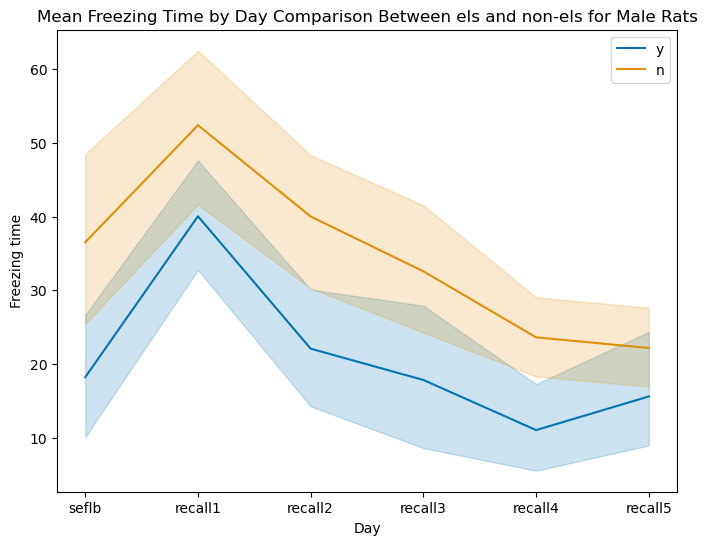

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


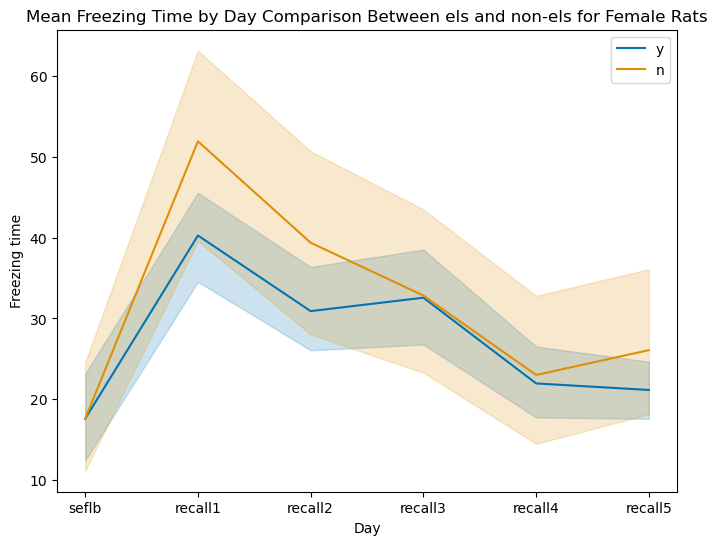

In [127]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=els_male, x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind") 
plt.xlabel('Day')
plt.ylabel('Freezing time')
plt.title('Mean Freezing Time by Day Comparison Between els and non-els for Male Rats')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(data=els_female, x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind") 
plt.xlabel('Day')
plt.ylabel('Freezing time')
plt.title('Mean Freezing Time by Day Comparison Between els and non-els for Female Rats')
plt.legend()
plt.show()

In [128]:
# ANOVA on freezing time for els and non-els male rats
els_male_anova = pg.mixed_anova(data=els_male, dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time for els and non-els Male rats:")
print(els_male_anova)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=els_male_anova['np2'].iloc[0], k=2, power=0.80))
print("There are {} els male rats in els groups".format(len(els_male[els_male['els']=='y']['id'].value_counts())))
print("There are {} non-els male rats in els groups".format(len(els_male[els_male['els']=='n']['id'].value_counts())))
## We observe a significant difference between els and non-els male rats, we meet the required sample size. 

# ANOVA on freezing time for els and non-els female rats
els_female_anova = pg.mixed_anova(data=els_female, dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time for els and non-els Female rats:")
print(els_female_anova)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=els_female_anova['np2'].iloc[0], k=2, power=0.80))
print("There are {} els female rats in els groups".format(len(els_female[els_female['els']=='y']['id'].value_counts())))
print("There are {} non-els female rats in els groups".format(len(els_female[els_female['els']=='n']['id'].value_counts())))
## We don't observe a significant difference between els and non-els female rats, and we do not meet the required sample size.

# so from this line, it seems like male rats will have a more significant difference between els and non-els groups than. 

repeated ANOVA for Freezing Time for els and non-els Male rats:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          els   8762.349602    1   29  8762.349602   8.275514  7.461434e-03   
1          day  16832.288007    5  145  3366.457601  22.776554  8.006986e-17   
2  Interaction    726.925699    5  145   145.385140   0.983637  4.299120e-01   

      p-GG-corr       np2      eps sphericity  W-spher   p-spher  
0           NaN  0.222009      NaN        NaN      NaN       NaN  
1  2.023386e-11  0.439901  0.62404      False  0.21611  0.000089  
2           NaN  0.032806      NaN        NaN      NaN       NaN  
The required sample size per group n: 14.7772
There are 16 els male rats in els groups
There are 15 non-els male rats in els groups
repeated ANOVA for Freezing Time for els and non-els Female rats:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          els   1038.908359    1   40  1038.908359   1.248481  2.705

In [129]:
data['young'] = data['age_at_sefla'] < 18.5
young_male = data[(data['young']==True) & (data['sex']=='male') & (data['cohort']!='els1') & (data['cohort']!='els2')]
old_male = data[(data['young']==False) & (data['sex']=='male') & (data['cohort']!='els1') & (data['cohort']!='els2')]
young_female = data[(data['young']==True) & (data['sex']=='female') & (data['cohort']!='els1') & (data['cohort']!='els2')]
old_female = data[(data['young']==False) & (data['sex']=='female') & (data['cohort']!='els1') & (data['cohort']!='els2')]

In [130]:
els_young_male = els_groups[(els_groups['young']==True) & (els_groups['sex']=='male') & (els_groups['els']=='y')]
els_old_male = els_groups[(els_groups['young']==False) & (els_groups['sex']=='male') & (els_groups['els']=='y')]
els_young_female = els_groups[(els_groups['young']==True) & (els_groups['sex']=='female') & (els_groups['els']=='y')]
els_old_female = els_groups[(els_groups['young']==False) & (els_groups['sex']=='female') & (els_groups['els']=='y')]

In [145]:
young_male_total = pd.concat([young_male, els_young_male], axis=0) 
old_male_total = pd.concat([old_male, els_old_male], axis=0) 
young_female_total = pd.concat([young_female, els_young_female], axis=0)
old_female_total = pd.concat([old_female, els_old_female], axis=0)

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


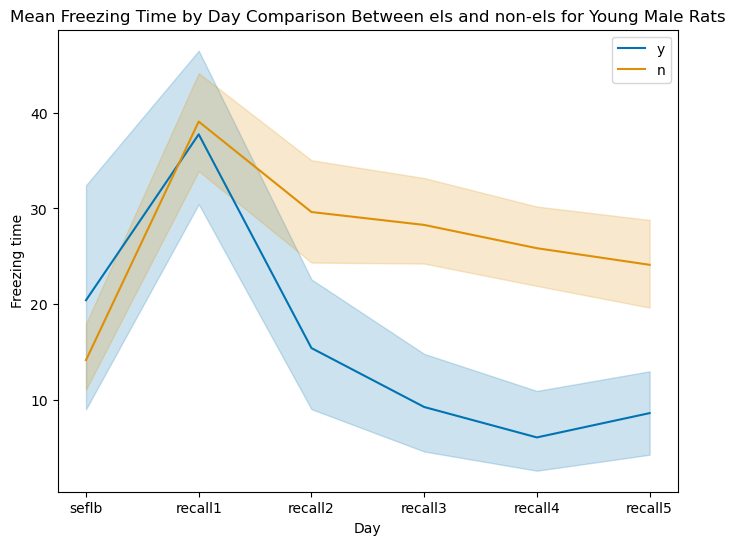

repeated ANOVA for Freezing Time for els and non-els Young Male rats:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          els   3146.894390    1   44  3146.894390   3.668513  6.196330e-02   
1          day  11586.704054    5  220  2317.340811  16.612666  6.544776e-14   
2  Interaction   3456.485663    5  220   691.297133   4.955805  2.547384e-04   

      p-GG-corr       np2       eps sphericity   W-spher       p-spher  
0           NaN  0.076959       NaN        NaN       NaN           NaN  
1  1.194217e-08  0.274079  0.603531      False  0.228905  2.908493e-08  
2           NaN  0.101230       NaN        NaN       NaN           NaN  
The required sample size per group n: 48.0490
There are 9 els young male rats in els groups
There are 57 non-els young male rats in els groups


In [159]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=young_male_total, x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind") 
plt.xlabel('Day')
plt.ylabel('Freezing time')
plt.title('Mean Freezing Time by Day Comparison Between els and non-els for Young Male Rats')
plt.legend()
plt.show()

anova_young_male = pg.mixed_anova(data=young_male_total, dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time for els and non-els Young Male rats:")
print(anova_young_male)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=anova_young_male['np2'].iloc[0], k=2, power=0.80))
print("There are {} els young male rats in els groups".format(len(young_male_total[young_male_total['els']=='y']['id'].value_counts())))
print("There are {} non-els young male rats in els groups".format(len(young_male_total[young_male_total['els']=='n']['id'].value_counts())))
## We observe a significant difference between els and non-els male rats, we meet the required sample size. 


/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


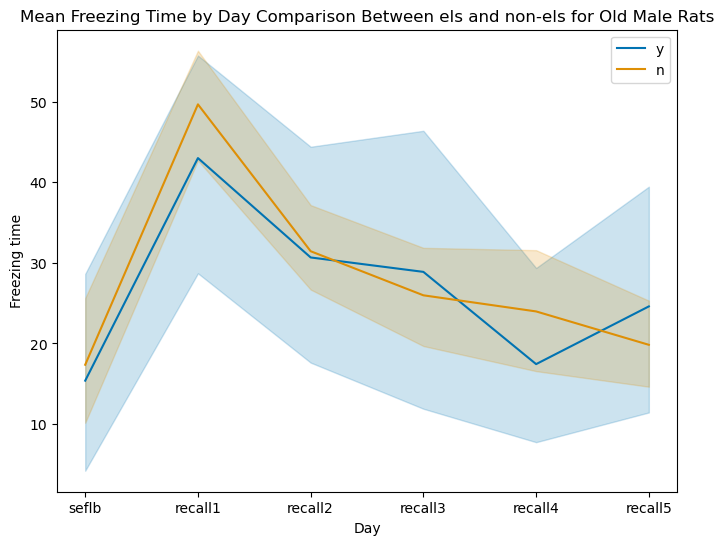

repeated ANOVA for Freezing Time for els and non-els Old Male rats:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          els     29.548853    1   24    29.548853   0.022154  8.829224e-01   
1          day  16324.609451    5  120  3264.921890  28.373132  6.805723e-19   
2  Interaction    622.541297    5  120   124.508259   1.082013  3.738535e-01   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.000922       NaN        NaN       NaN       NaN  
1  9.148390e-14  0.541750  0.684322      False  0.306963  0.018208  
2           NaN  0.043139       NaN        NaN       NaN       NaN  
The required sample size per group n: 4252.4473
There are 7 els old male rats in els groups
There are 27 non-els old male rats in els groups


In [161]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=old_male_total, x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind") 
plt.xlabel('Day')
plt.ylabel('Freezing time')
plt.title('Mean Freezing Time by Day Comparison Between els and non-els for Old Male Rats')
plt.legend()
plt.show()

anova_old_male = pg.mixed_anova(data=old_male_total, dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time for els and non-els Old Male rats:")
print(anova_old_male)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=anova_old_male['np2'].iloc[0], k=2, power=0.80))
print("There are {} els old male rats in els groups".format(len(old_male_total[old_male_total['els']=='y']['id'].value_counts())))
print("There are {} non-els old male rats in els groups".format(len(old_male_total[old_male_total['els']=='n']['id'].value_counts())))
## No significant difference between els and non-els groups for old male rats 

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


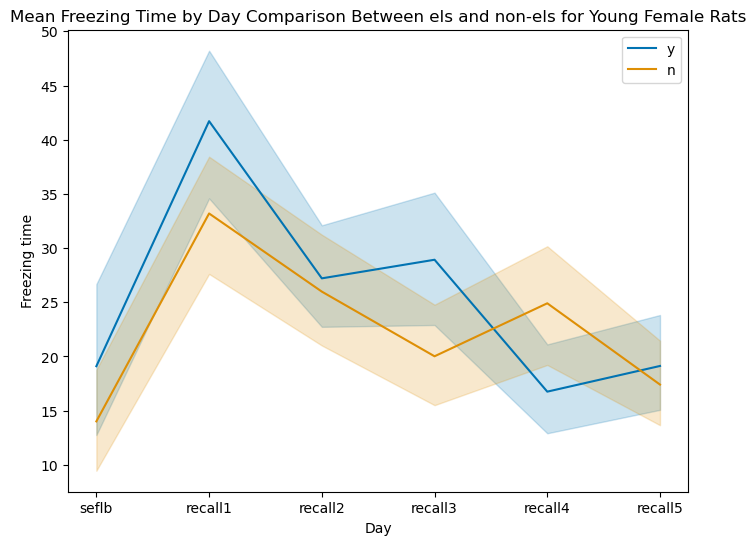

repeated ANOVA for Freezing Time for els and non-els Young Female rats:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          els   1331.730154    1   46  1331.730154   2.047650  1.592002e-01   
1          day  14272.054703    5  230  2854.410941  31.190656  3.464191e-24   
2  Interaction   1976.231358    5  230   395.246272   4.318926  8.939010e-04   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.042617       NaN        NaN       NaN       NaN  
1  4.490599e-19  0.404073  0.810898      False  0.494974  0.004441  
2           NaN  0.085831       NaN        NaN       NaN       NaN  
The required sample size per group n: 89.1321
There are 21 els young female rats in els groups
There are 31 non-els young female rats in els groups


In [162]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=young_female_total, x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind") 
plt.xlabel('Day')
plt.ylabel('Freezing time')
plt.title('Mean Freezing Time by Day Comparison Between els and non-els for Young Female Rats')
plt.legend()
plt.show()

anova_young_female = pg.mixed_anova(data=young_female_total, dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time for els and non-els Young Female rats:")
print(anova_young_female)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=anova_young_female['np2'].iloc[0], k=2, power=0.80))
print("There are {} els young female rats in els groups".format(len(young_female_total[young_female_total['els']=='y']['id'].value_counts())))
print("There are {} non-els young female rats in els groups".format(len(young_female_total[young_female_total['els']=='n']['id'].value_counts())))
## No significant difference between els and non-els groups for old male rats 

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


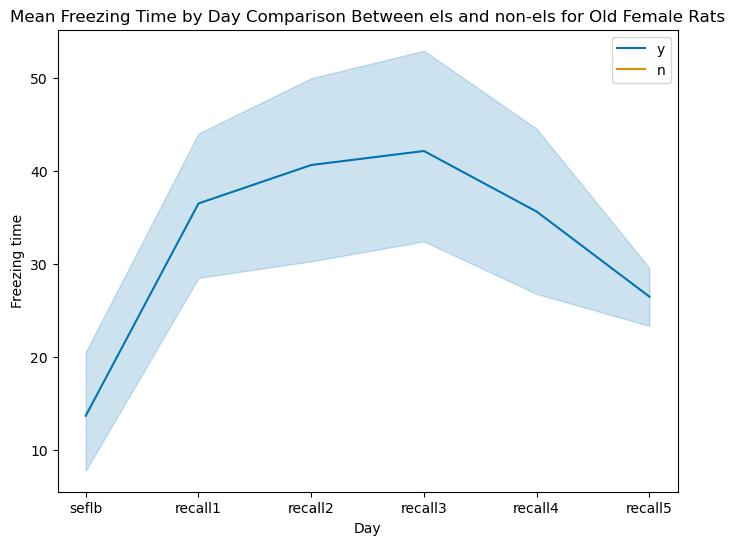

repeated ANOVA for Freezing Time for els and non-els Old Female rats:
        Source            SS  DF1  DF2          MS         F     p-unc  \
0          els  0.000000e+00    0    7         NaN       NaN       NaN   
1          day  4.614227e+03    5   35  922.845475  9.254667  0.000011   
2  Interaction  1.818989e-12    0   35         inf       inf       NaN   

            np2       eps  
0  0.000000e+00       NaN  
1  5.693544e-01  0.588523  
2  5.211874e-16       NaN  
The required sample size per group n: nan
There are 8 els old female rats in els groups
There are 0 non-els old female rats in els groups


/Users/novak/anaconda3/lib/python3.11/site-packages/pingouin/parametric.py:1006: RuntimeWarning: invalid value encountered in scalar divide
  msbetween = ssbetween / ddof1
/Users/novak/anaconda3/lib/python3.11/site-packages/pingouin/parametric.py:1542: RuntimeWarning: divide by zero encountered in scalar divide
  ms_inter = ss_inter / df_inter


In [163]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=old_female_total, x='day', y='freezing', hue='els', hue_order=['y', 'n'], palette="colorblind") 
plt.xlabel('Day')
plt.ylabel('Freezing time')
plt.title('Mean Freezing Time by Day Comparison Between els and non-els for Old Female Rats')
plt.legend()
plt.show()

anova_old_female = pg.mixed_anova(data=old_female_total, dv='freezing', within='day', between='els', subject='id', effsize="np2")
print("repeated ANOVA for Freezing Time for els and non-els Old Female rats:")
print(anova_old_female)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=anova_old_female['np2'].iloc[0], k=2, power=0.80))
print("There are {} els old female rats in els groups".format(len(old_female_total[old_female_total['els']=='y']['id'].value_counts())))
print("There are {} non-els old female rats in els groups".format(len(old_female_total[old_female_total['els']=='n']['id'].value_counts())))
## No significant difference between els and non-els groups for old male rats 